# Dependence:
- tensorflow-gpu 1.11
- keras 2.2.4

# Training

In [5]:
import os
import numpy as np
import glob
import cv2

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator( rotation_range=90,
                              brightness_range=[0.1,0.8],
                             width_shift_range=0.2,
                             height_shift_range=0.2,
#                              shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='constant',cval=255,                     
#                              rescale=1./255,
#                              channel_shift_range=0.2,
                             vertical_flip=True)

def imagepreprocessing(I):
    image = load_img(I).resize([224,224])
    image = img_to_array(image)  
    I = image
#     I = image/255
    return I

testdir = './data/my_crop/'
len([lists for lists in os.listdir(testdir) if os.path.isfile(os.path.join(testdir, lists))])

for parent,dirnames,filenames in os.walk(testdir): 
    for dirname in dirnames:     
        test_dir = parent+dirname
        print("test dir is:" +test_dir)
        imagenum = len([lists for lists in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, lists))])

        i = 0
        testimage = np.zeros(shape=(imagenum,224,224,3))

        for img_name in glob.glob(test_dir+'/*.jpg'):
            testimage[i,:,:,:] =  imagepreprocessing(img_name)
            i +=1  
        print(testimage.shape)

        i = 0
        save_path = './data/my_crop_aug/'+dirname
        
        if os.path.isdir(save_path): 
            pass
        else:
            os.makedirs(save_path) 

        for batch in datagen.flow(testimage, 
                                  batch_size=32,
                                  save_to_dir=save_path,  
                                  save_format='jpg'):
            i +=1
            if i ==(np.ceil(imagenum/32)*10):
                break 

test dir is:./data/my_crop/Tomato___Bacterial_spot
(34, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Early_blight
(61, 224, 224, 3)
test dir is:./data/my_crop/Tomato___healthy
(82, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Late_blight
(63, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Leaf_Mold
(57, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Septoria_leaf_spot
(51, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Spider_mites Two-spotted_spider_mite
(18, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Target_Spot
(11, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Tomato_mosaic_virus
(111, 224, 224, 3)
test dir is:./data/my_crop/Tomato___Tomato_Yellow_Leaf_Curl_Virus
(112, 224, 224, 3)


In [ ]:
import keras.layers as layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dropout, Dense,Input
from keras import applications,optimizers
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint

model = applications.InceptionV3(include_top=False, weights='imagenet')
# model = applications.VGG16(include_top=False, weights='imagenet')
imagesize =224

input = layers.Input(shape=(imagesize,imagesize,3),name='image_input')

x = layers.GlobalMaxPooling2D()(model(input))
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('softmax',name='pred')(x) 

model = Model(inputs = input, outputs= x)
# model.summary()


train_data_dir = './data/train/'

BATCH_SIZE =24
datagen = ImageDataGenerator(  rescale=1. / 255,
                             brightness_range=[0.1,0.8],
                             channel_shift_range=0.5,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rotation_range=0.2,
                             width_shift_range=[-30,30],
                             height_shift_range=[-30,30],                               
                             zoom_range=0.2
                            )
train_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='validation')
# print(train_generator.class_indices)

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

callbacks = [
    ModelCheckpoint(filepath="./model/10Inception_1117.h5", verbose=1, save_best_only=True),
    TensorBoard(log_dir="./log/10Inception_1117"),
]

model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator),
                    validation_data=validation_generator,
                    epochs=50,
                    shuffle=True,
                    callbacks=callbacks)

# Test and  Confusion matrix

In [2]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
inception_model = load_model('./model/Inception_0401.h5')
vgg_model = load_model('./model/VGG16_0401.h5')
test_data_dir = './data/test/'

imagesize = 224
BATCH_SIZE = 24

datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = datagen.flow_from_directory(directory=test_data_dir,
                                             shuffle=False,
                                             target_size=(imagesize, imagesize), 
                                             batch_size=BATCH_SIZE    )


ince_re= inception_model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)
vgg_re= vgg_model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)
print(ince_re)
print(vgg_re)

Found 2169 images belonging to 10 classes.
91/91 [==============================] - 31s 339ms/step
[0.1641106806144139, 0.956662054708225]
[0.21424702287266445, 0.9423697514982474]


In [4]:
from matplotlib  import pyplot as plt
import itertools
from sklearn.metrics import  confusion_matrix
import numpy as np
test_generator = datagen.flow_from_directory(directory=test_data_dir,
                                             shuffle=False,
                                             target_size=(imagesize, imagesize), 
                                             batch_size=BATCH_SIZE    )
pred = model.predict_generator(test_generator,verbose=1,steps=len(test_generator))
pred_lable = np.argmax(pred, axis=1)
cnf_matrix = confusion_matrix(test_generator.classes,pred_lable)

Found 2169 images belonging to 10 classes.
91/91 [==============================] - 13s 141ms/step


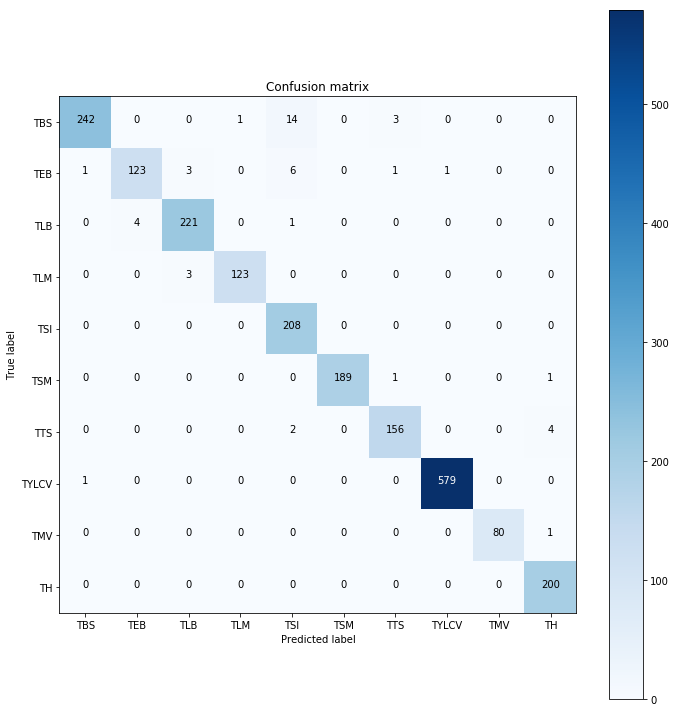

In [5]:
label = list(set(test_generator.classes))
classes = ['TBS',  'TEB',  'TLB', 'TLM',  'TSl', 'TSM',  'TTS',  'TYLCV','TMV', 'TH' ]
a = classes
# a = []
# for i in label:
#     a.append(classes[i])
    
plt.figure(figsize=(10,10))   
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks =  np.arange(len(a))
plt.xticks(tick_marks, a, )
plt.yticks(tick_marks, a)

thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if cnf_matrix[i,j] ==0:
        text1 = cnf_matrix[i,j]
        fmt = 'd'
#         text1 = 'N'
#         fmt = 's'
         
    else:
        text1 = cnf_matrix[i,j]
        fmt = 'd'
    plt.text(j, i, format(text1, fmt),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Transfer '.h5' model to '.pb' model

In [ ]:
import tensorflow as tf
import os

from tensorflow.python.framework import graph_util

from keras.models import load_model
from keras import backend as K


path_to_model = './model/10Inception_1117_1.h5'
model = load_model(path_to_model)

K.set_learning_phase(0)

sess = K.get_session()
output_fld = './model/'
if not os.path.isdir(output_fld):
    os.mkdir(output_fld)
    
output_graph_name =  '10Inception_1117_1.pb'
ouputname = model.output.name

constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), [ouputname[0:-2] ])
tf.train.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', os.path.join(output_fld, output_graph_name))


# Check the scope name of  '.pb' model 

In [ ]:
import tensorflow as tf

with tf.gfile.GFile('./model/10Inception_1117_1.pb', "rb") as f:  
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Graph().as_default() as graph:  
    tf.import_graph_def(graph_def, name="")  
    for op in graph.get_operations(): 
        print(op.name, )